# Wykrywanie naczyń dna siatkówki oka
Katarzyna Chojniak, grupa L5, 155978

Użyte biblioteki:

In [242]:
import numpy as np
import matplotlib.pyplot as plt
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from skimage.filters import gaussian, frangi, hessian, meijering, apply_hysteresis_threshold, threshold_otsu, threshold_local
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import joblib
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk
from skimage import img_as_bool
import cv2

### 1. Wczytywanie i wybór obrazu

Na początku algorytm umożliwia wybór pliku obrazu z katalogu oraz wczytuje odpowiadające mu maskę oraz maskę ekspercką.

In [324]:
mask = None
img = None
manual1 = None

def load_mask(file_name):
    global mask
    mask_path = 'mask/' + file_name.split('.')[0] + '_mask.tif'
    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
    else:
        print(f"Mask file {mask_path} does not exist.")
        mask = None
    
def load_image(file_name):
    global img
    image_path = 'images/' + file_name
    if os.path.exists(image_path):
        img = cv2.imread(image_path, cv2.IMREAD_COLOR_RGB)
        
    else:
        print(f"Image file {image_path} does not exist.")
        img = None
    
def load_manual(file_name):
    global manual1
    manual_path = 'manual1/' + file_name.split('.')[0] + '.tif'
    if os.path.exists(manual_path):
        manual1 = cv2.imread(manual_path, cv2.IMREAD_GRAYSCALE)
    else:
        print(f"Manual file {manual_path} does not exist.")
        manual1 = None


def read_img(image):
    path = 'images/' + image
    return cv2.imread(path, cv2.IMREAD_COLOR_RGB)

def read_mask(image):
    path = 'mask/' + image.split('.')[0] + '_mask.tif'
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def read_manual(image):
    path = 'manual1/' + image.split('.')[0] + '.tif'
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

Dropdown(index=38, options=('01_dr.JPG', '01_g.jpg', '01_h.jpg', '02_dr.JPG', '02_g.jpg', '02_h.jpg', '03_dr.J…

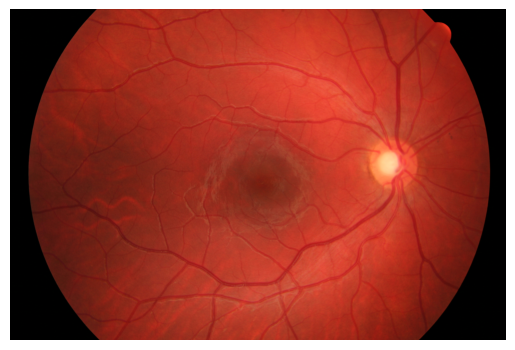

In [4]:
dir = 'images/'
directory_files = os.listdir(dir)
file_name = directory_files[0]

load_image(file_name)
load_mask(file_name)
load_manual(file_name)

picker = widgets.Dropdown(options=directory_files, disabled=False, )
display(picker)

plt.imshow(img)
plt.axis('off')

def on_change(change):
    clear_output()
    display(picker)
    global img, file_name
    file_name = change.new
    load_image(file_name)
    load_mask(file_name)
    load_manual(file_name)
    plt.imshow(img)
    plt.axis('off')
    


picker.observe(on_change, names='value')


### 2. Preprocessing obrazu wraz z przykładami wyników

Ograniczenie przetwarzania obrazu do kanału zielonego

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

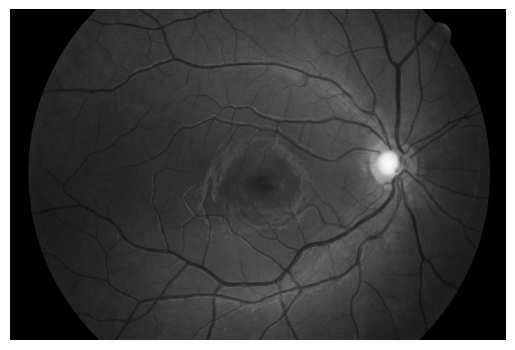

In [301]:
def set_green_channel(image):
    return image[:, :, 1]

green_channel = set_green_channel(img)
plt.imshow(green_channel, cmap='gray')
plt.axis('off')

Odszumianie i normalizacja

Zmiana rozmiaru obrazu do (3504, 2336), normalizacja kolorów - w razie, gdyby nie były one w standardowych rozmiarach

Następnie odszumianie metodą fastNlMeansDenoising.

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

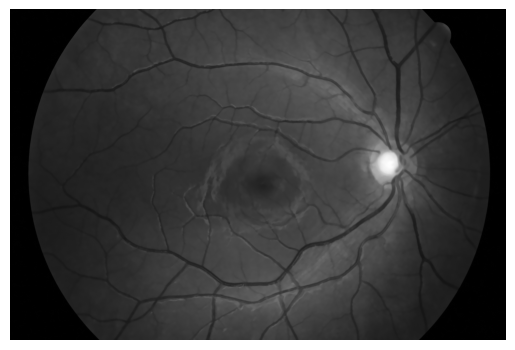

In [303]:
def denoise_image(image):
    resized = cv2.resize(image, (3504, 2336), interpolation=cv2.INTER_AREA)
    normalized = cv2.normalize(resized, None, 0, 255, cv2.NORM_MINMAX)

    noise_removed = cv2.fastNlMeansDenoising(normalized, None, 10, 7, 21)

    return noise_removed

noise_removed = denoise_image(green_channel)
plt.imshow(noise_removed, cmap='gray')
plt.axis('off')

Wyrównanie histogramu (CLAHE)

Aby poprawić kontrast i lepiej uwidocznić naczynia, stosowane jest adaptacyjne wyrównanie histogramu CLAHE. Dodatkowo pokazuję przykład sześciu różnych zestawów parametrów.
Wybrałam clipLimit=2.0 oraz tileGridSize=(300,300)

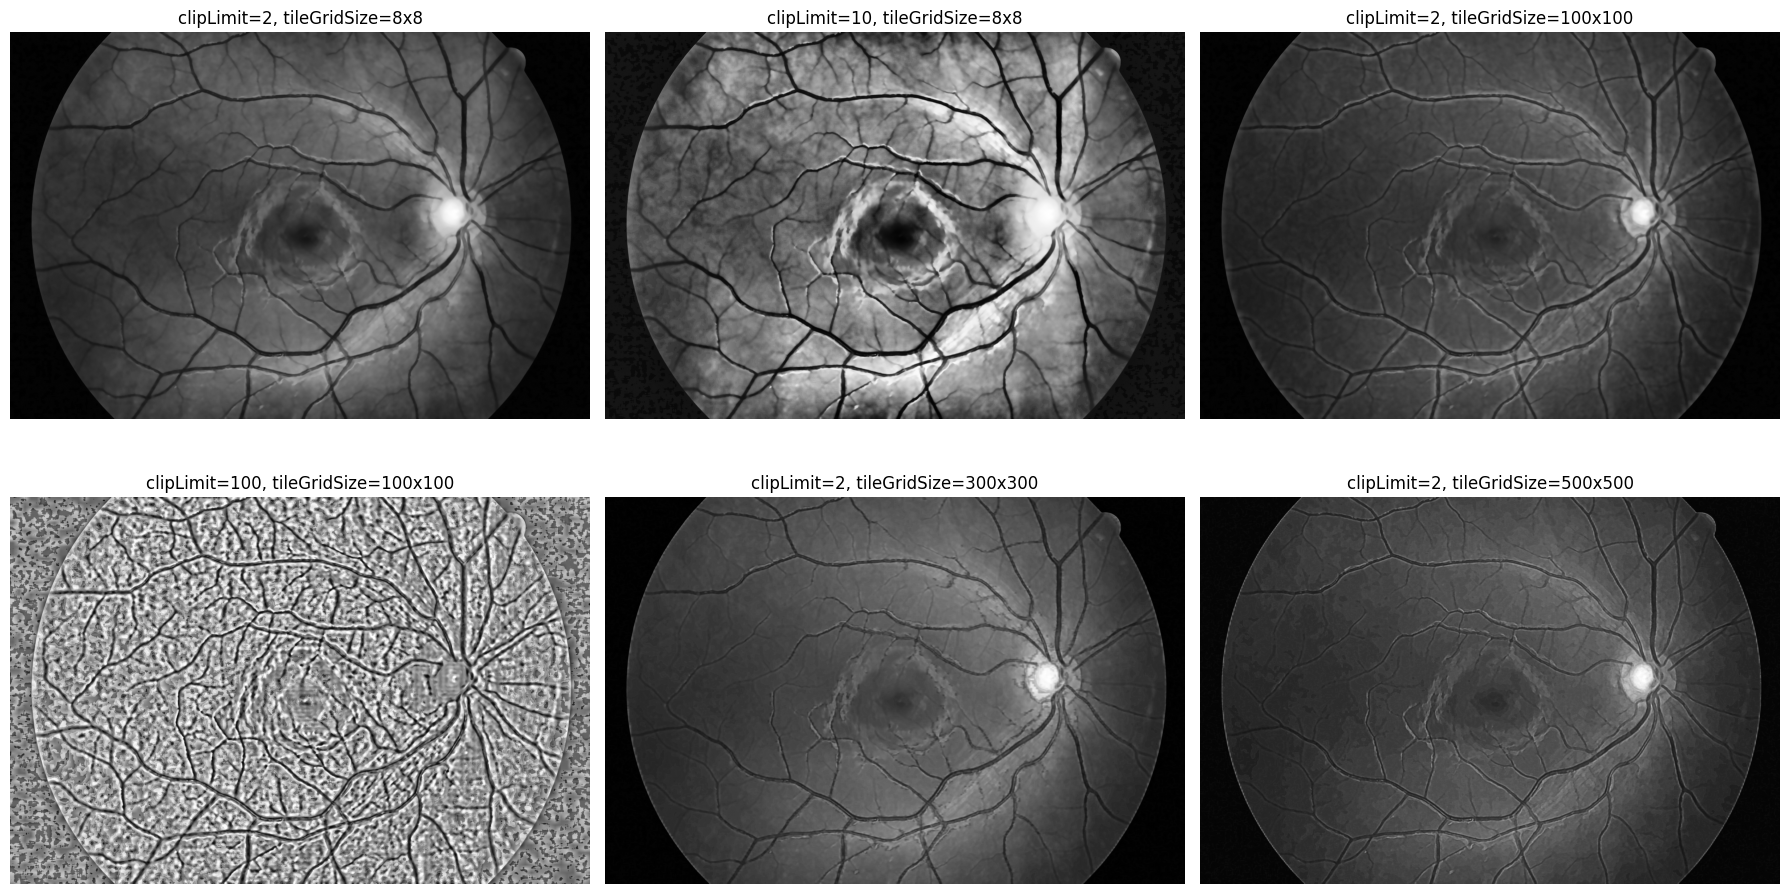

In [304]:
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(300, 300))

    # clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(128, 128))

    equalized = clahe.apply(image.astype(np.uint8))
    return equalized


clahe_params = [
    (2, (8, 8)),
    (10, (8, 8)),
    (2, (100, 100)),
    (100, (100, 100)),
    (2, (300, 300)),
    (2, (500, 500)),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (clip, grid) in enumerate(clahe_params):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=grid)
    result = clahe.apply(noise_removed.astype(np.uint8))
    axes[idx].imshow(result, cmap='gray')
    axes[idx].set_title(f'clipLimit={clip}, tileGridSize={grid[0]}x{grid[1]}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

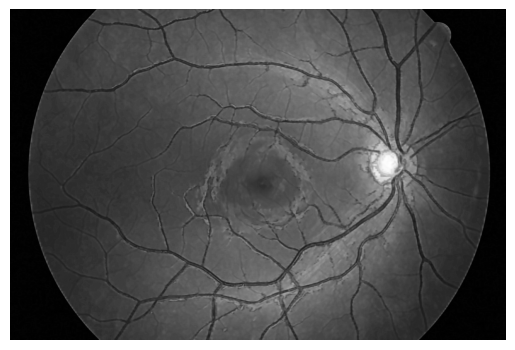

In [305]:
equalized = apply_clahe(noise_removed)
plt.imshow(equalized, cmap='gray')
plt.axis('off')

Wyostrzanie i rozmycie obrazu w celu dalszego uwydotnienienia naczyń

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

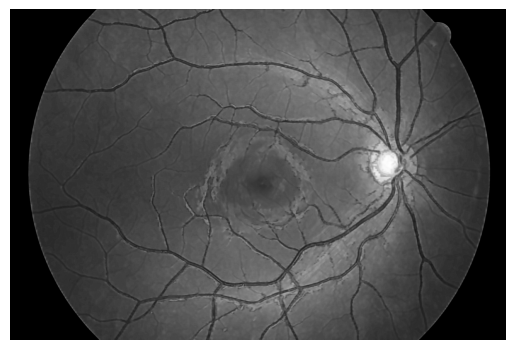

In [306]:
def apply_gausian_blur(image):
    smoothed = cv2.GaussianBlur(image, (9, 9), 0)
    sharpened = cv2.addWeighted(image, 1.5, smoothed, -0.5, 0)
    return cv2.bitwise_and(sharpened, mask)

preprocessed_image = apply_gausian_blur(equalized)

plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')

Wspólna funkcja, która wykonuje wszystkie poprzednie przetwarzania w odpowiedniej kolejności

In [307]:
def preprocess_image(image):
    gc = set_green_channel(image)
    denoise = denoise_image(gc)
    equalized = apply_clahe(denoise)
    blurred = apply_gausian_blur(equalized)
    return blurred

### 3. Właściwe przetwarzanie - filtr Frangiego

Do detekcji naczyń krwionośnych wykorzystywany jest filtr Frangiego, który powinien wykrywać naczynia w przedziale (1,8) pikseli, z niską alphą (0.1), betą (0.1) i stosunkowo niską gammą (5)

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

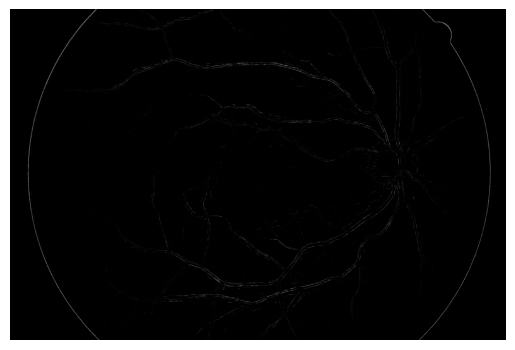

In [326]:
def apply_framgi_filter(image):
    # Apply Frangi filter
    frangi_img = frangi(image, sigmas=range(1, 8), alpha=0.1, beta=0.1, gamma=5)
    return frangi_img

frangi_img = apply_framgi_filter(preprocessed_image)

plt.imshow(frangi_img, cmap='gray')
plt.axis('off')

### 4. Końcowe Przetwarzanie obrazu
Wykorzystanie hysteresis_threshold, aby zachować główne naczynia oraz ewentualne, cienkie przylegające do nich.

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

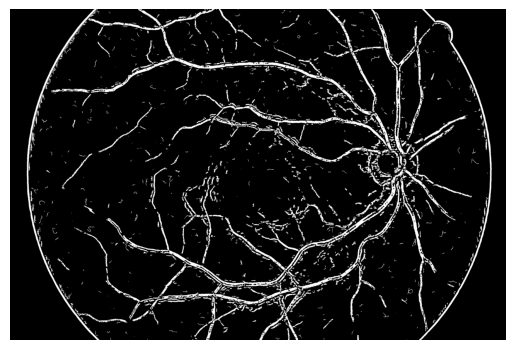

In [327]:
def apply_threshold(img_for_threshold):
    low = 0.001
    high = 0.1

    hyst = apply_hysteresis_threshold(img_for_threshold, low, high).astype(np.uint8)

    return hyst

hyst = apply_threshold(frangi_img)

plt.imshow(hyst, cmap='gray')
plt.axis('off')

Przetwarzanie morfologiczne, które ma na celu usunięcie artefaktów oraz dodatkowe wypełnienie naczyń.

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

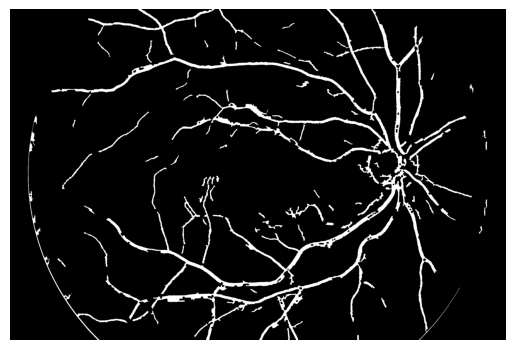

In [328]:
def postprocess_image(hyst):
    postprococessed_img = cv2.bitwise_and(hyst, hyst, mask=mask)

    binary = img_as_bool(postprococessed_img > 0.5)
    postprococessed_img = remove_small_objects(binary, min_size=350)
    postprococessed_img = remove_small_holes(postprococessed_img, area_threshold=500)
    postprococessed_img = closing(postprococessed_img, disk(5))
    return postprococessed_img


postprococessed_img = postprocess_image(hyst)
plt.imshow(postprococessed_img, cmap='gray')
plt.axis('off')

Porównanie z maską ekspercką

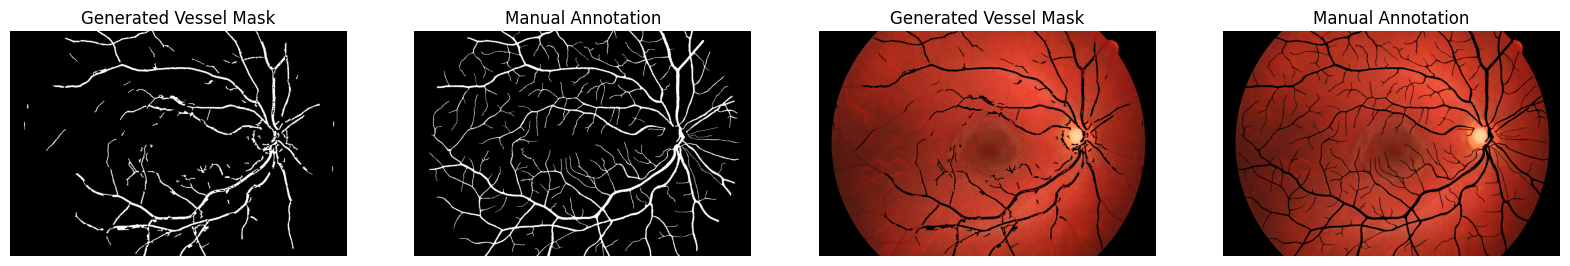

In [321]:
def compare_with_manual(generated_img, manual_img):
    # Ensure both images are the same size
    if generated_img.shape != manual_img.shape:
        manual_resized = cv2.resize(manual_img, (generated_img.shape[1], generated_img.shape[0]))
    else:
        manual_resized = manual_img

    # Normalize images to binary if needed
    gen_bin = (generated_img > 0).astype(np.uint8)
    man_bin = (manual_resized > 0).astype(np.uint8)

    # Show images side by side
    plt.figure(figsize=(20,10))
    plt.subplot(1,4,1)
    plt.imshow(gen_bin, cmap='gray')
    plt.title('Generated Vessel Mask')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(man_bin, cmap='gray')
    plt.title('Manual Annotation')
    plt.axis('off')

    # Show images
    global img
    inv_gen = 1 - gen_bin
    gen_overlay = cv2.bitwise_and(img, img, mask=inv_gen)
    inv_man = 1 - man_bin
    man_overlay = cv2.bitwise_and(img, img, mask=inv_man)

    plt.subplot(1,4,3)
    plt.imshow(gen_overlay)
    plt.title('Generated Vessel Mask')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(man_overlay)
    plt.title('Manual Annotation')
    plt.axis('off')
    plt.show()


# Example usage:
compare_with_manual(postprococessed_img, manual1)

In [ ]:
test_images = [
    '14_dr.JPG', '14_h.jpg', '14_g.jpg',
    '15_dr.JPG', '15_h.jpg', '15_g.jpg'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

results_frangi = []

for idx, fname in enumerate(test_images):
    img = read_img(fname)
    mask = read_mask(fname)
    manual = read_manual(fname)
    processed_img = preprocess_image(img)
    frangi_img = apply_framgi_filter(processed_img)
    hyst = apply_threshold(frangi_img)
    postprococessed_img = postprocess_image(hyst)

    axes[idx].imshow(postprococessed_img, cmap='gray')
    axes[idx].set_title(fname)
    axes[idx].axis('off')

    # Przygotowanie do obliczeń metryk
    manual_bin = (cv2.resize(manual, (postprococessed_img.shape[1], postprococessed_img.shape[0])) > 0).astype(np.uint8)
    pred_bin = postprococessed_img.astype(np.uint8)

    # Flatten do obliczeń
    y_true = manual_bin.flatten()
    y_pred = pred_bin.flatten()

    # Macierz pomyłek
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

    # Metryki
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    mean_arith = (sensitivity + specificity) / 2
    mean_geom = np.sqrt(sensitivity * specificity)


    results_frangi.append({
        'file': fname,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'mean_arith': mean_arith,
        'mean_geom': mean_geom,
        'confusion_matrix': cm
    })

plt.tight_layout()
plt.show()

# Wyświetlenie metryk dla każdego obrazu
for res in results_frangi:
    print(f"{res['file']}:")
    print(f"  Accuracy: {res['accuracy']:.4f}")
    print(f"  Sensitivity: {res['sensitivity']:.4f}")
    print(f"  Specificity: {res['specificity']:.4f}")
    print(f"  Mean (arith): {res['mean_arith']:.4f}")
    print(f"  Mean (geom): {res['mean_geom']:.4f}")
    print(f"  Confusion matrix:\n{res['confusion_matrix']}\n")

In [253]:
patch_size = 31

In [254]:
def extract_pixel_patches_with_labels(image, manual, mask, patch_size=patch_size):
    h, w = manual.shape
    pad = patch_size // 2
    padded_image = np.pad(image, pad_width=pad, mode='reflect')

    x_train = []
    y_train = []

    valid_pixels = np.sum(mask != 0)
    print(f"Number of valid pixels in mask: {valid_pixels}")

    # Pre-allocate arrays
    x_train = np.zeros((valid_pixels, patch_size * patch_size), dtype=image.dtype)
    y_train = np.zeros((valid_pixels,), dtype=manual.dtype)

    print(f"Extracting patches of size {patch_size}x{patch_size}...")

    idx = 0
    for i in range(h):
        for j in range(w):
            if mask[i, j] == 0:
                continue

            patch = padded_image[i:i+patch_size, j:j+patch_size]
            x_train[idx, :] = patch.flatten()
            y_train[idx] = manual[i, j]
            idx += 1

    return x_train, y_train

In [290]:
# images_for_training = ['04_dr.JPG', '05_dr.JPG', '04_g.jpg', '05_g.jpg', '04_h.jpg', '05_h.jpg']
images_for_training = ['06_dr.JPG', '10_h.jpg', '11_g.jpg']

all_x = []
all_y = []


for fname in images_for_training:
    img = read_img(fname)
    mask = read_mask(fname)
    manual = read_manual(fname)

    processed_img = preprocess_image(img)
    # processed_img = set_green_channel(img)

    x_train, y_train = extract_pixel_patches_with_labels(processed_img, manual, mask)

    # Under-sample the majority class
    # rus = RandomUnderSampler(sampling_strategy={0: 100000, 255: 50000}, random_state=42)
    rus = RandomUnderSampler(random_state=42)

    x_resampled, y_resampled = rus.fit_resample(x_train, y_train)

    print(f"Resampled dataset shape: {Counter(y_resampled)}")

    all_x.append(x_resampled)
    all_y.append(y_resampled)
    
all_x = np.vstack(all_x)
all_y = np.hstack(all_y)

Number of valid pixels in mask: 6914251
Extracting patches of size 31x31...
Resampled dataset shape: Counter({np.uint8(0): 617844, np.uint8(255): 617844})
Number of valid pixels in mask: 6913259
Extracting patches of size 31x31...
Resampled dataset shape: Counter({np.uint8(0): 705438, np.uint8(255): 705438})
Number of valid pixels in mask: 6913339
Extracting patches of size 31x31...
Resampled dataset shape: Counter({np.uint8(0): 625555, np.uint8(255): 625555})


In [291]:
X_train, X_test, Y_train, Y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=42, stratify=all_y)

In [292]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

clf.fit(X_train, Y_train)

joblib.dump(clf, 'random_forest_5_6' + '.pkl')

['random_forest_5_6.pkl']

In [293]:
y_pred_train = clf.predict(X_train)

print(classification_report(Y_train, y_pred_train, target_names=["Background", "Vessel"]))
cm = confusion_matrix(Y_train, y_pred_train)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

  Background       1.00      1.00      1.00   1559069
      Vessel       1.00      1.00      1.00   1559070

    accuracy                           1.00   3118139
   macro avg       1.00      1.00      1.00   3118139
weighted avg       1.00      1.00      1.00   3118139

Confusion Matrix:
 [[1559064       5]
 [      0 1559070]]


In [294]:
y_pred_test = clf.predict(X_test)

print(classification_report(Y_test, y_pred_test, target_names=["Background", "Vessel"]))
cm = confusion_matrix(Y_test, y_pred_test)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

  Background       0.94      0.95      0.94    389768
      Vessel       0.95      0.94      0.94    389767

    accuracy                           0.94    779535
   macro avg       0.94      0.94      0.94    779535
weighted avg       0.94      0.94      0.94    779535

Confusion Matrix:
 [[370412  19356]
 [ 24015 365752]]


In [295]:
def reconstruct_image(predictions, image_shape):
    h, w = image_shape
    reconstructed_img = np.zeros((h, w), dtype=predictions.dtype)
    
    coords = np.argwhere(mask != 0)  # get pixel coords in same order as extraction
    
    for idx, (i, j) in enumerate(coords):
        reconstructed_img[i, j] = predictions[idx]
    
    return reconstructed_img

In [296]:
def extract_pixel_patches(image, mask, patch_size=patch_size):
    h, w = mask.shape
    pad = patch_size // 2
    padded_image = np.pad(image, pad_width=pad, mode='reflect')

    coords = np.argwhere(mask != 0)
    n = len(coords)
    x_test = np.zeros((n, patch_size * patch_size), dtype=image.dtype)

    for idx, (i, j) in enumerate(coords):
        patch = padded_image[i:i+patch_size, j:j+patch_size]
        x_test[idx, :] = patch.flatten()

    return x_test, coords

Extracted 6914369 patches for testing.
Predictions made for 6914369 patches.


(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

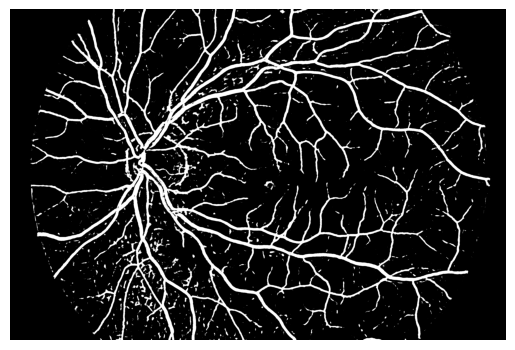

In [ ]:
model = joblib.load('random_forest_5_6.pkl')

image_path = 'images/02_h.jpg'
test_img = cv2.imread(image_path, cv2.IMREAD_COLOR_RGB)
test_img = preprocess_image(test_img)

mask = cv2.imread('mask/02_h_mask.tif', cv2.IMREAD_GRAYSCALE)

x_test, coords = extract_pixel_patches(test_img, mask)
print(f"Extracted {len(x_test)} patches for testing.")

predictions = model.predict(x_test)
print(f"Predictions made for {len(predictions)} patches.")

reconstructed_img = reconstruct_image(predictions, test_img.shape)
plt.imshow(reconstructed_img, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

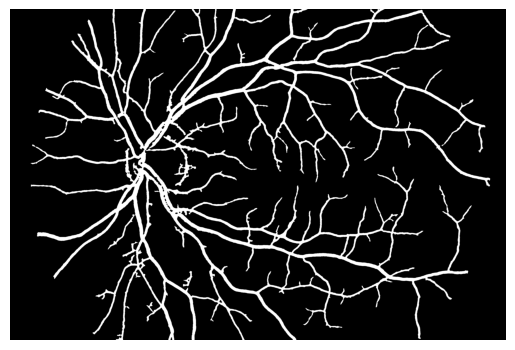

In [331]:
binary = reconstructed_img > 0.5
gg = remove_small_objects(img_as_bool(binary), min_size=2000)
gg = closing(gg, disk(3))

plt.imshow(gg, cmap='gray')
plt.axis('off')

In [338]:
def batch_predict(model, x_test, batch_size=10000):
    """Wykonuje predykcję na dużym zbiorze danych w partiach."""
    n = x_test.shape[0]
    preds = np.zeros(n, dtype=np.uint8)
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        preds[start:end] = model.predict(x_test[start:end])
    return preds

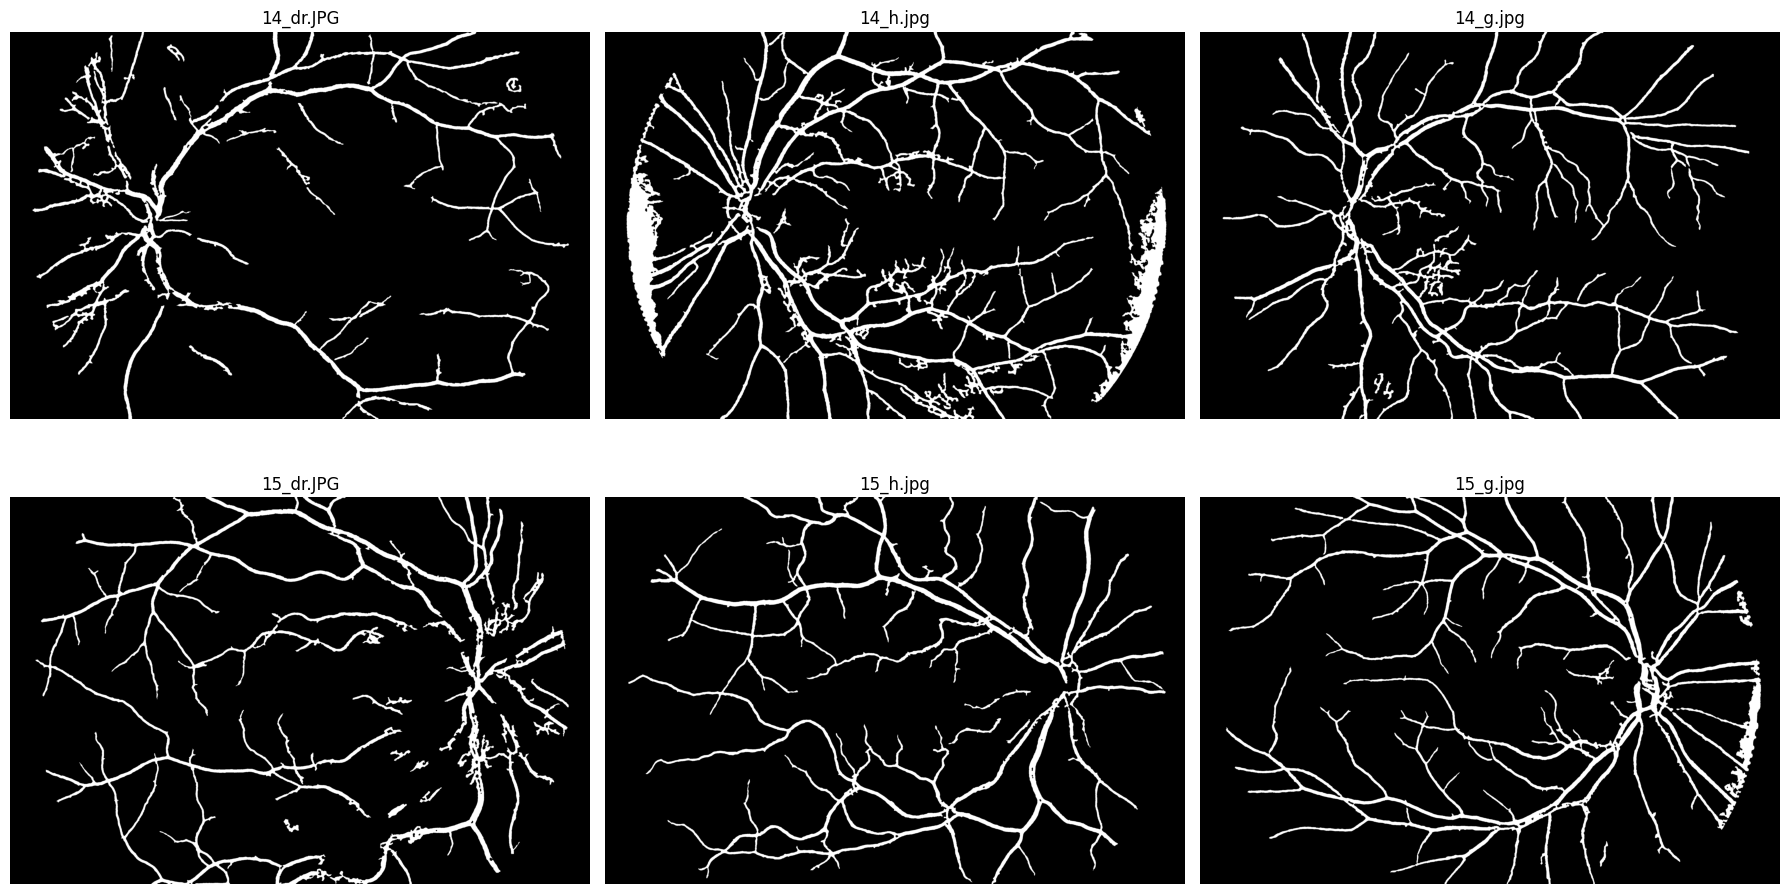

14_dr.JPG:
  Accuracy: 0.9454
  Sensitivity: 0.5888
  Specificity: 0.9748
  Confusion matrix:
[[7370054  190354]
 [ 256967  367969]]

14_h.jpg:
  Accuracy: 0.9154
  Sensitivity: 0.8043
  Specificity: 0.9260
  Confusion matrix:
[[6918239  553051]
 [ 139764  574290]]

14_g.jpg:
  Accuracy: 0.9492
  Sensitivity: 0.7387
  Specificity: 0.9652
  Confusion matrix:
[[7342355  264820]
 [ 151052  427117]]

15_dr.JPG:
  Accuracy: 0.9483
  Sensitivity: 0.7545
  Specificity: 0.9619
  Confusion matrix:
[[7358675  291626]
 [ 131355  403688]]

15_h.jpg:
  Accuracy: 0.9607
  Sensitivity: 0.7410
  Specificity: 0.9794
  Confusion matrix:
[[7388710  155389]
 [ 166109  475136]]

15_g.jpg:
  Accuracy: 0.9478
  Sensitivity: 0.7599
  Specificity: 0.9626
  Confusion matrix:
[[7302542  283614]
 [ 143854  455334]]



In [ ]:
test_images = [
    '14_dr.JPG', '14_h.jpg', '14_g.jpg',
    '15_dr.JPG', '15_h.jpg', '15_g.jpg'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
results_postprocessed = []

for idx, fname in enumerate(test_images):
    img = read_img(fname)
    mask = read_mask(fname)
    manual = read_manual(fname)
    processed_img = preprocess_image(img)
    x_test, coords = extract_pixel_patches(processed_img, mask)
    
    # Batch prediction
    predictions = batch_predict(model, x_test, batch_size=10000)
    reconstructed_img = reconstruct_image(predictions, processed_img.shape)
    binary = reconstructed_img > 0.5

    # Postprocessing: remove small objects, connect lines
    gg = remove_small_objects(img_as_bool(binary), min_size=2000)
    gg = closing(gg, disk(3))

    axes[idx].imshow(gg, cmap='gray')
    axes[idx].set_title(fname)
    axes[idx].axis('off')

    # Prepare for metrics
    manual_bin = (cv2.resize(manual, (gg.shape[1], gg.shape[0])) > 0).astype(np.uint8)
    pred_bin = gg.astype(np.uint8)

    y_true = manual_bin.flatten()
    y_pred = pred_bin.flatten()

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    mean_arith = (sensitivity + specificity) / 2
    mean_geom = np.sqrt(sensitivity * specificity)

    results_postprocessed.append({
        'file': fname,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'mean_arith': mean_arith,
        'mean_geom': mean_geom,
        'confusion_matrix': cm
    })

plt.tight_layout()
plt.show()

for res in results_postprocessed:
    print(f"{res['file']}:")
    print(f"  Accuracy: {res['accuracy']:.4f}")
    print(f"  Sensitivity: {res['sensitivity']:.4f}")
    print(f"  Specificity: {res['specificity']:.4f}")
    print(f"  Mean (arith): {res['mean_arith']:.4f}")
    print(f"  Mean (geom): {res['mean_geom']:.4f}")
    print(f"  Confusion matrix:\n{res['confusion_matrix']}\n")

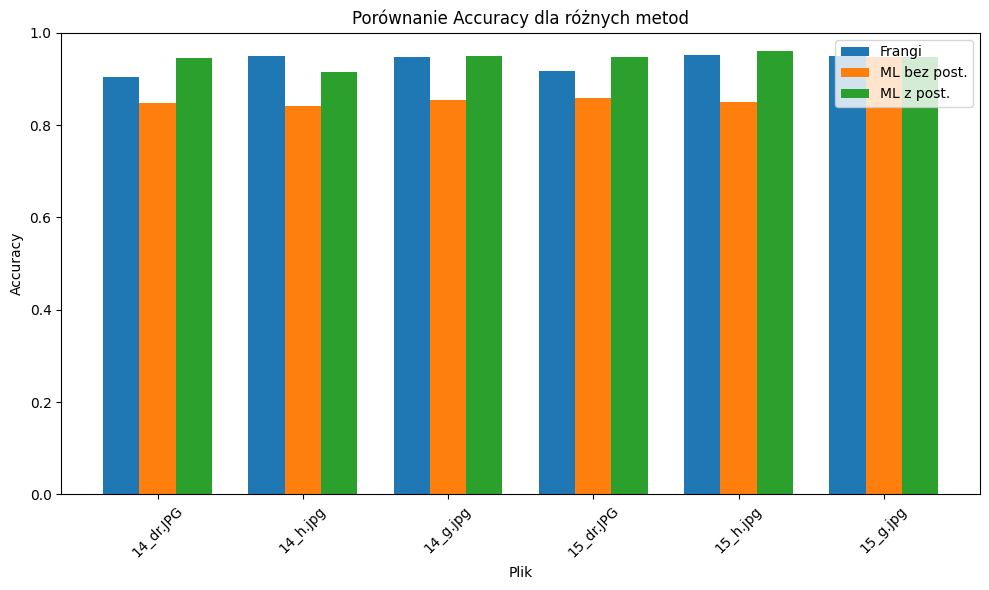

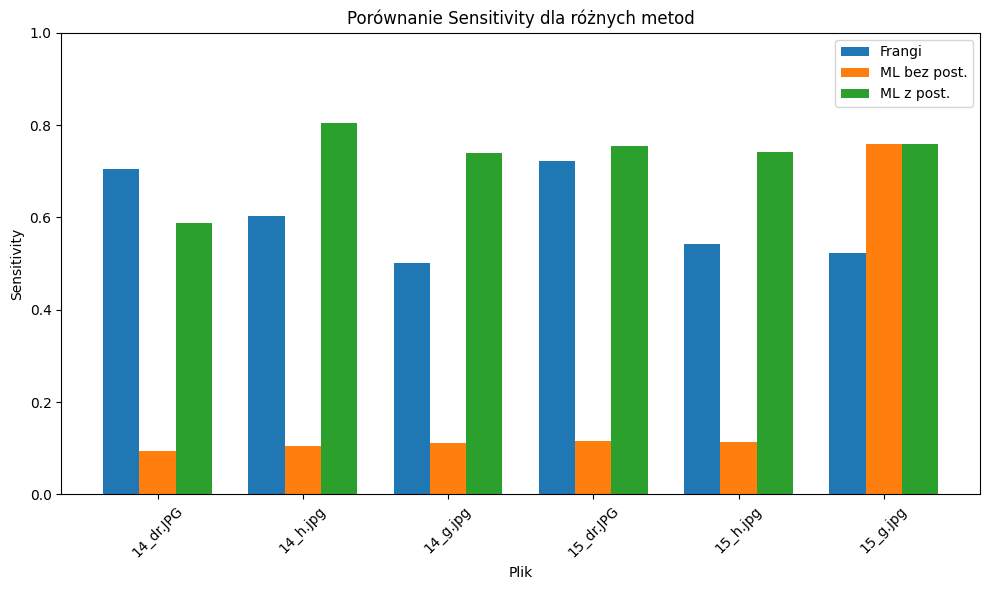

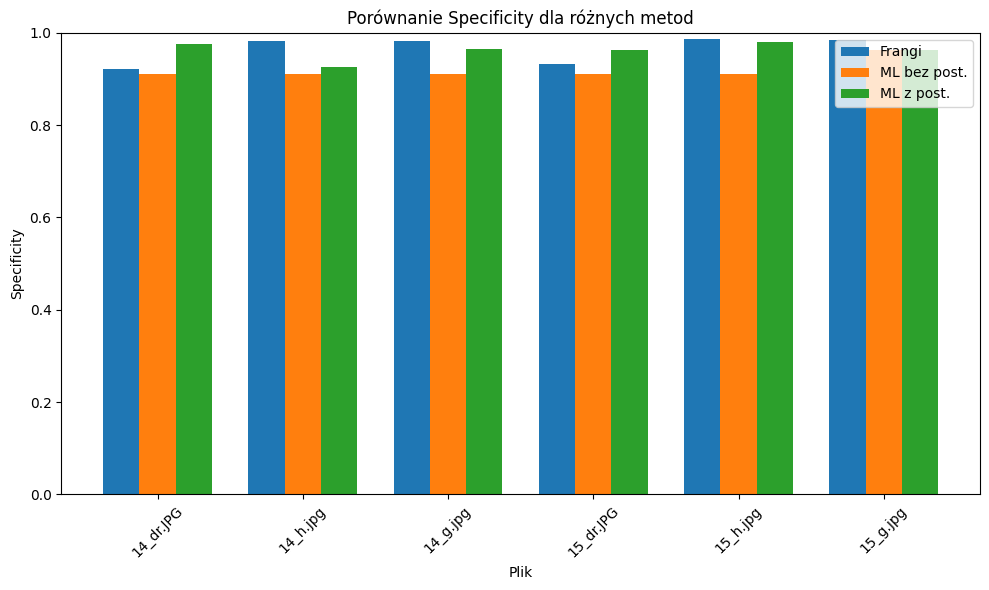

In [ ]:
files = ['14_dr.JPG', '14_h.jpg', '14_g.jpg', '15_dr.JPG', '15_h.jpg', '15_g.jpg']

# Zamień na numpy array dla łatwiejszego rysowania
def extract_metric(results, metric):
    return [r[metric] for r in results]

metrics = ['accuracy', 'sensitivity', 'specificity', 'mean_arith', 'mean_geom']
labels = ['Frangi', 'ML bez post.', 'ML z post.', 'śr. arytm.', 'śr. geo.']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    x = np.arange(len(files))
    width = 0.35

    plt.bar(x - width/2, extract_metric(results_frangi, metric), width, label='Frangi')
    plt.bar(x + width/2, extract_metric(results_postprocessed, metric), width, label='ML')

    plt.ylabel(metric.capitalize())
    plt.xlabel('Plik')
    plt.title(f'Porównanie {metric.capitalize()} dla różnych metod')
    plt.xticks(x, files, rotation=45)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()